# [Land Cover Classification of Satellite Imagery using Convolutional Neural Networks](https://towardsdatascience.com/land-cover-classification-of-satellite-imagery-using-convolutional-neural-networks-91b5bb7fe808)
This uses 1D filters
For regression: https://www.kaggle.com/code/guidosalimbeni/regression-with-convolutional-neural-network-keras/notebook

In [29]:
# !wget http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat 

In [31]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
data = loadmat('Salinas_corrected.mat')['salinas_corrected']
print(f"(nrows, ncols, nbands) = {data.shape}")

# reshape matrix into a dataframe, (but how to know nearness?)
# One shape dimension can be -1. In this case, the value is inferred
# from the length of the array and remaining dimensions
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
print(f"new shape: {df.shape}")
df['class'] = gt.ravel()
# add output columns
df.head()

(nrows, ncols, nbands) = (512, 217, 204)
new shape: (111104, 204)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band196,band197,band198,band199,band200,band201,band202,band203,band204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,83,105,83,48,75,50,24,9,17,0


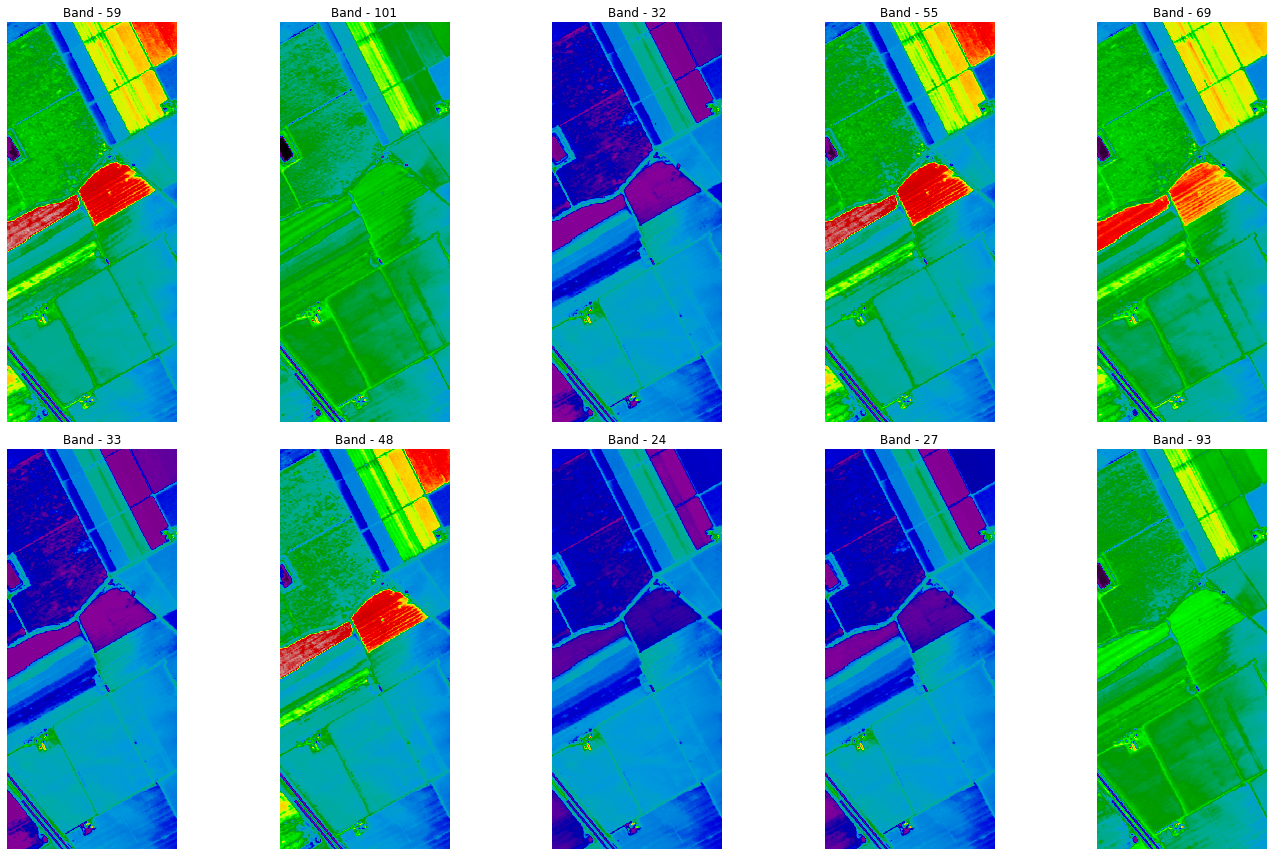

In [32]:
# viz

fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
    for j in range(5):
        c = np.random.randint(103)
        ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()
plt.show()

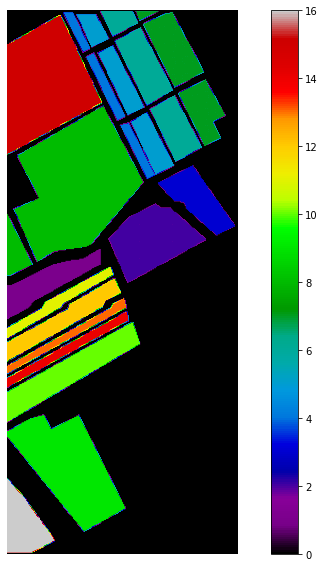

In [33]:
def plot_data(data):
    fig = plt.figure(figsize=(12, 10))
    plt.imshow(data, cmap='nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.show()

plot_data(gt)

In [36]:
# scale data
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale

t_df = df[df['class']!=0]
ind = ['band'+str(i) for i in range(1, t_df.shape[-1])]
X = t_df.loc[:, ind]
y = to_categorical(t_df.loc[:, 'class'])
X_scaled = minmax_scale(X, axis = 0);
X_scaled.shape, y.shape

((54129, 204), (54129, 17))

In [38]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}") 

X_train: (37890, 204)
y_train: (37890, 17)
X_test: (16239, 204)
y_test: (16239, 17)


In [43]:
# change shape to (nentries, nclassees, 1)
X_train = X_train.reshape(-1, 204, 1)
X_test = X_test.reshape(-1, 204, 1)

# define input shape, num output...
ip_shape = X_train[1].shape
n_outputs = y_train.shape[1]
X_train[1].ravel().shape

(204,)

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [47]:
model = Sequential(name = 'Salinas_CNN')

# add three 1D convolutional layers
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu',
                 input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu',
                 name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu',
                 name = 'Layer3'))

# add max-pooling layer with dropout rate=0.4
model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

# add three 1D convolutional layers
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu',
                 name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu',
                 name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu',
                 name = 'Layer6'))

# add max-pooling layer with dropout rate=0.4
model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))
model.add(Dense(25, activation='relu', name = 'DenseLayer'))
model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))


model.summary()

2022-04-30 17:36:40.130555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Salinas_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 202, 64)           256       
                                                                 
 Layer2 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 Layer3 (Conv1D)             (None, 198, 64)           12352     
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 99, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 99, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 97, 32)            6176      
                                                       

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
from time import time

early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [51]:
hist = model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       batch_size = 256 , 
                       validation_data = (X_test, y_test), 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

Epoch 1/100
149/149 [==============================] - 22s 144ms/step - loss: 1.4105 - accuracy: 0.5112 - val_loss: 0.6609 - val_accuracy: 0.7583
Epoch 2/100
149/149 [==============================] - 21s 142ms/step - loss: 0.5590 - accuracy: 0.7727 - val_loss: 0.3965 - val_accuracy: 0.8337
Epoch 3/100
 39/149 [======>.......................] - ETA: 14s - loss: 0.4624 - accuracy: 0.8142

KeyboardInterrupt: 

In [ ]:
hist = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

# [SpectralNET a 2D wavelet CNN for Hyperspectral Image Classification.](https://github.com/tanmay-ty/SpectralNET)
**Paper**: http://arxiv.org/abs/2104.00341